# U-NET Pytorch Implementation

## Dataset Creation

In [3]:
import torch
from torch.nn.functional import relu
import torch.nn as nn
from torch.nn.functional import interpolate
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import h5py
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

2024-05-21 09:49:35.512341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 09:49:35.512465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 09:49:35.638431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Defining the Architecture

In [4]:

class EncoderBlock(torch.nn.Module):
    def __init__(self,in_filter,out_filter):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_filter, out_filter, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filter, out_filter, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

In [5]:
# Decoder
class DecoderBlock(torch.nn.Module):
    def __init__(self,in_filter,out_filter):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_filter, out_filter, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_filter, out_filter, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filter, out_filter, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

In [6]:


class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = self.crop_and_concat(xu1, xe42)
        #xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = self.crop_and_concat(xu2, xe32)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = self.crop_and_concat(xu3, xe22)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = self.crop_and_concat(xu4, xe12)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = interpolate(out, size = x.shape[2:], mode ='bilinear', align_corners=True)
        return out
    
    
    def crop_and_concat(self, upsampled, bypass):
        # Get the shape of the upsampled tensor
        _, C, H_up, W_up = upsampled.size()

        # Get the shape of the bypass tensor
        _, _, H_bypass, W_bypass = bypass.size()

        # Calculate the cropping indices based on the difference in heights and widths
        crop_h = (H_bypass - H_up) // 2
        crop_w = (W_bypass - W_up) // 2

        # Crop the bypass tensor to match the size of the upsampled tensor
        cropped_bypass = bypass[:, :, crop_h:crop_h+H_up, crop_w:crop_w+W_up]

        # Concatenate the upsampled and cropped bypass tensors
        concatenated = torch.cat((upsampled, cropped_bypass), dim=1)

        return concatenated

## Training the Model

In [7]:
# Create the model
model = UNet(1)
model = model.to('cuda')
loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # Adjust this learning rate appropriately!!!

In [8]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        with h5py.File(file_path, 'r') as hdf:
            self.x_data = torch.tensor(hdf['xtrain'][:].astype('float32'))
            self.y_data = torch.tensor(hdf['ytrain'][:].astype('float32'))

        # Compute mean and std for normalization
        self.x_mean = self.x_data.mean()
        self.x_std = self.x_data.std()
        self.y_mean = self.y_data.mean()
        self.y_std = self.y_data.std()

        # Normalize the data
        self.x_data = (self.x_data - self.x_mean) / self.x_std
        self.y_data = (self.y_data - self.y_mean) / self.y_std

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx].clone().detach().unsqueeze(0)
        y = self.y_data[idx].clone().detach().unsqueeze(0)
        return x, y

# Define the dataset
dataset = CustomDataset('/kaggle/input/sino-data/Sinogram.h5')

# Split the dataset into training and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define the data loaders for training and validation sets
batch_size = 16
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size)


In [7]:
# Epoch Trainer Function
scaler = GradScaler()
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(training_loader):
        inputs, true_val = data
        inputs, true_val = inputs.to('cuda'), true_val.to('cuda')

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = loss_fn(outputs, true_val)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        if i % batch_size == batch_size-1:
            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [8]:
# Initialize variables
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/ring_remover_{}_lr_1e-4'.format(timestamp))

EPOCHS = 100
patience = 2
last_best_epoch = 0
saved_model_paths = []
best_vloss = 1_000_000.

# Gradient Scaler for mixed precision training
scaler = GradScaler()
accumulation_steps = 4  # For gradient accumulation
batch_size = 4  # Start with a smaller batch size

# Define the dataset and DataLoader
dataset = CustomDataset('/kaggle/input/image-domain/Image.h5')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    model.train(True)
    optimizer.zero_grad()

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, true_val = data
        inputs, true_val = inputs.to('cuda'), true_val.to('cuda')

        with autocast():
            outputs = model(inputs)
            loss = loss_fn(outputs, true_val)
            loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()

        # Optional: Clear cache every few iterations
        if i % 100 == 0:
            torch.cuda.empty_cache()

    avg_loss = running_loss / len(dataloader)
    
    # Validation
    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to('cuda'), vlabels.to('cuda')
            with autocast():
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(validation_loader)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch)
        torch.save(model.state_dict(), model_path)
        saved_model_paths.append(model_path)
        last_best_epoch = epoch
        
        # Remove the unneeded models except the last two best models
        if len(saved_model_paths) > patience:
            model_to_remove = saved_model_paths.pop(0)
            os.remove(model_to_remove)
            print("Removed model:", model_to_remove)
    else:
        if epoch - last_best_epoch > patience:
            print("Validation loss hasn't improved in {} epochs. Early stopping...".format(patience))
            break

print('Finished Training')

EPOCH 1:
LOSS train 0.020594944423161603 valid 0.002557908193372737
EPOCH 2:
LOSS train 0.0003568673505974908 valid 0.0007710563828974651
EPOCH 3:
LOSS train 0.00014645862564874632 valid 0.0004514144133108424
Removed model: model_20240521_054552_0
EPOCH 4:
LOSS train 0.00010513099107536994 valid 0.0003944850214461367
Removed model: model_20240521_054552_1
EPOCH 5:
LOSS train 9.321191476099933e-05 valid 0.0003530148485532707
Removed model: model_20240521_054552_2
EPOCH 6:
LOSS train 8.752739231134737e-05 valid 0.00033295986837142015
Removed model: model_20240521_054552_3
EPOCH 7:
LOSS train 8.497764136856338e-05 valid 0.00033574520758910306
EPOCH 8:
LOSS train 8.445259580127192e-05 valid 0.00030599339336890446
Removed model: model_20240521_054552_4
EPOCH 9:
LOSS train 7.768388009242786e-05 valid 0.0003083861068132267
EPOCH 10:
LOSS train 7.868104186912653e-05 valid 0.00029184505226675396
Removed model: model_20240521_054552_5
EPOCH 11:
LOSS train 7.157051119238964e-05 valid 0.0002794658

## Evaluation

In [ ]:
# Load the Model
model = UNet(1).to('cuda')
model.load_state_dict(torch.load("/kaggle/working/model_20240521_054552_16"))
model.eval()  

In [ ]:
x, y = train_dataset[70]
x = x.unsqueeze(0).to('cuda').float()

In [11]:
print(x.shape)

torch.Size([1, 1, 888, 984])


In [12]:
x = x.squeeze(0)  # Remove the first dimension (batch_size)
x = x.unsqueeze(0)
with torch.no_grad():
    with torch.cuda.amp.autocast():
        output = model(x)

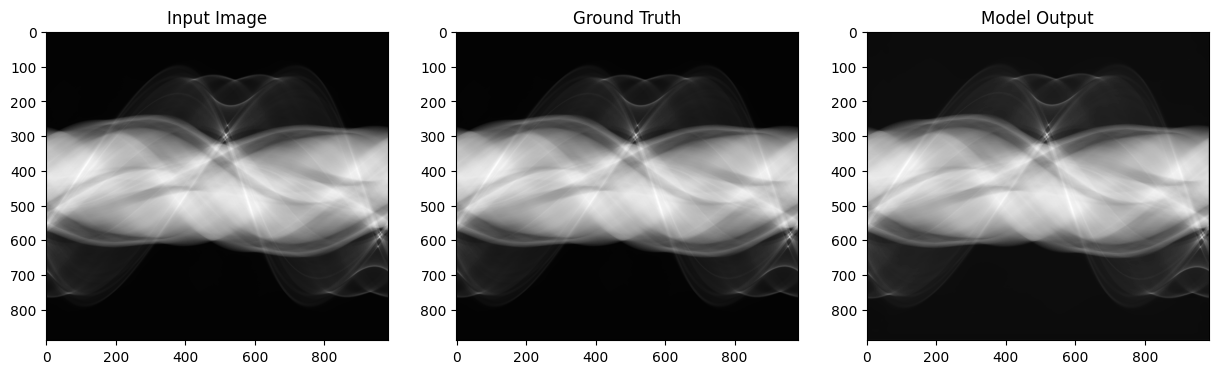

In [13]:
# Assuming output is a single-channel segmentation map
output = output.cpu().squeeze().squeeze().numpy()

# Visualize the input and output
input_image = x.cpu().squeeze().numpy()
target_image = y.cpu().squeeze().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Input Image')
ax[1].imshow(target_image, cmap='gray')
ax[1].set_title('Ground Truth')
ax[2].imshow(output, cmap='gray')
ax[2].set_title('Model Output')
plt.show()

In [21]:

from scipy.io import savemat

savemat('input_image.mat', {'input_image': input_image})
savemat('target_image.mat', {'target_image': target_image})
savemat('output.mat', {'output': output})

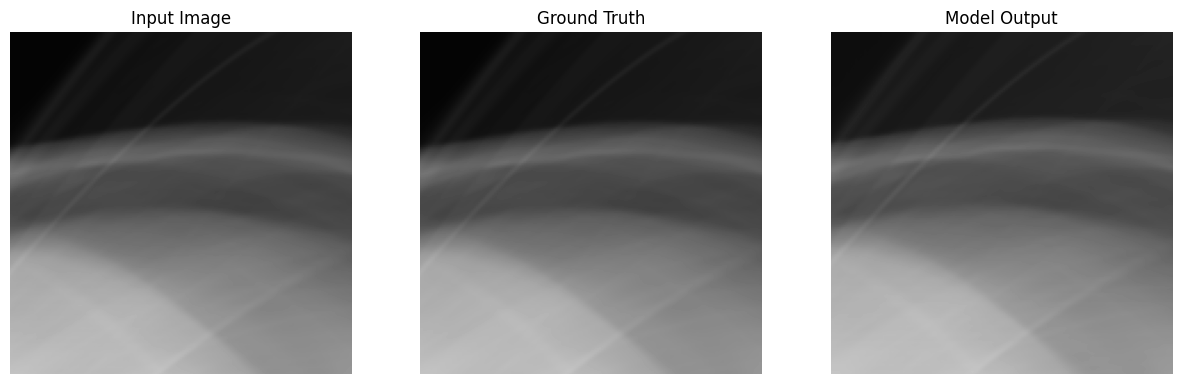

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Input Image')
ax[0].axis('off')  # Turn off axis

# Display the ground truth
ax[1].imshow(target_image, cmap='gray')
ax[1].set_title('Ground Truth')
ax[1].axis('off')  # Turn off axis

# Display the model output
ax[2].imshow(output, cmap='gray')
ax[2].set_title('Model Output')
ax[2].axis('off')  # Turn off axis

# Zoom in on the model output
zoom_start_x, zoom_end_x = 200, 350  # Adjust these values as needed
zoom_start_y, zoom_end_y = 200, 350  # Adjust these values as needed
ax[0].set_xlim(zoom_start_x, zoom_end_x)
ax[0].set_ylim(zoom_end_y, zoom_start_y)
ax[1].set_xlim(zoom_start_x, zoom_end_x)
ax[1].set_ylim(zoom_end_y, zoom_start_y)
ax[2].set_xlim(zoom_start_x, zoom_end_x)
ax[2].set_ylim(zoom_end_y, zoom_start_y)
plt.show()